In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Cell 2 — TensorFlow Configuration (GPU, Precision, XLA)

In [2]:
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))
print("Logical devices:", tf.config.list_logical_devices())

tf.config.optimizer.set_jit(False)   # keep OFF


# Seed
SEED = 42
tf.keras.utils.set_random_seed(SEED)

TF version: 2.10.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [3]:
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


TF version: 2.10.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")
print("Policy:", mixed_precision.global_policy())


Policy: <Policy "float32">


# Cell 3 -Load CSV Flies

In [5]:
# ✅ Train on augmented images
TRAIN_DIR = "SurgWound_Augmented"
TRAIN_CSV = os.path.join(TRAIN_DIR, "train_aug_data.csv")

# ✅ Validate/Test on clean images
CLEAN_DIR = "SurgWound_Cleaned"
VAL_CSV   = os.path.join(CLEAN_DIR, "validation_data.csv")
TEST_CSV  = os.path.join(CLEAN_DIR, "test_data.csv")

assert os.path.exists(TRAIN_CSV), "Missing train_aug_data.csv"
assert os.path.exists(VAL_CSV), "Missing validation_data.csv"
assert os.path.exists(TEST_CSV), "Missing test_data.csv"
print("✅ CSVs found")


✅ CSVs found


#  Cell 4 — Load & Filter Erythema Samples

In [6]:
def load_task(df, task_key="erythema"):
    df = df.copy()
    df = df[df["image_id"].astype(str).str.contains(task_key, case=False, na=False)]
    df = df[df["answer"].astype(str).str.lower() != "uncertain"]
    df["answer"] = df["answer"].astype(str).str.strip()
    df["filename"] = (
        df["filename"].astype(str)
        .str.replace("\\\\", "/", regex=False)
        .str.replace("\\", "/", regex=False)
    )
    return df.reset_index(drop=True)

train_df = load_task(pd.read_csv(TRAIN_CSV), "erythema")
val_df   = load_task(pd.read_csv(VAL_CSV),   "erythema")
test_df  = load_task(pd.read_csv(TEST_CSV),  "erythema")

print("Train:\n", train_df["answer"].value_counts())
print("Val:\n", val_df["answer"].value_counts())
print("Test:\n", test_df["answer"].value_counts())


Train:
 answer
Non-existent    2004
Existent         774
Name: count, dtype: int64
Val:
 answer
Non-existent    44
Existent        22
Name: count, dtype: int64
Test:
 answer
Non-existent    91
Existent        40
Name: count, dtype: int64


# Cell 5 — Dataset Sanity Check

In [7]:
p = os.path.join(TRAIN_DIR, train_df["filename"].iloc[0])
print("Example train file:", train_df["filename"].iloc[0])
print("Exists?", os.path.exists(p))
assert os.path.exists(p), "❌ Train augmented image path mismatch."
print("✅ Paths OK")


Example train file: train/images/0.jpg_erythema.jpg
Exists? True
✅ Paths OK


# Cell 6 — Image Size & Data Generators

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8   # if still OOM -> 4



# Cell 7 — Class Imbalance Handling

In [9]:
train_datagen = ImageDataGenerator(
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    rotation_range=30,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.20,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()  # clean, no augmentation

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col="answer",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=CLEAN_DIR,
    x_col="filename",
    y_col="answer",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=CLEAN_DIR,
    x_col="filename",
    y_col="answer",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

print("✅ class_indices:", train_gen.class_indices)
NUM_CLASSES = len(train_gen.class_indices)
assert NUM_CLASSES == 2, "Expected 2 classes for erythema."


Found 2778 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
✅ class_indices: {'Existent': 0, 'Non-existent': 1}


# Cell 8 — Training Utilities (Compile & Fit)

In [10]:
y_train = np.array(train_gen.classes, dtype=int)
classes = np.arange(NUM_CLASSES, dtype=int)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", CLASS_WEIGHTS)


Class weights: {0: 1.7945736434108528, 1: 0.6931137724550899}


# Cell 9,10 — Evaluation & Threshold Optimization

In [11]:
def freeze_bn(model):
    for l in model.layers:
        if isinstance(l, layers.BatchNormalization):
            l.trainable = False

def compile_model(model, lr, label_smoothing=0.0):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    if label_smoothing and label_smoothing > 0:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=label_smoothing)
    else:
        loss_fn = "sparse_categorical_crossentropy"

    model.compile(optimizer=opt, loss=loss_fn, metrics=["accuracy"])
    return model

def fit_model(model, epochs, lr):
    compile_model(model, lr=lr)
    cbs = [
        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ]
    return model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        class_weight=CLASS_WEIGHTS,
        callbacks=cbs,
        verbose=1,
        workers=1,
        use_multiprocessing=False
    )


In [12]:
def predict_probs(model, loader):
    probs = model.predict(loader, verbose=0)
    probs = np.array(probs)
    if probs.ndim == 1:
        probs = np.stack([1 - probs, probs], axis=1)
    return probs

def eval_on_test(model):
    probs = predict_probs(model, test_gen)
    y_pred = np.argmax(probs, axis=1)
    y_true = np.array(test_gen.classes, dtype=int)
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    return acc, f1w, y_true, y_pred, probs

def best_threshold_on_val(model):
    probs = predict_probs(model, val_gen)
    y_val = np.array(val_gen.classes, dtype=int)

    # pick positive class index safely
    if "Existent" in train_gen.class_indices:
        ex_idx = train_gen.class_indices["Existent"]
    else:
        ex_idx = 1  # fallback: assume class 1 is positive

    p_ex = probs[:, ex_idx]
    best_t, best_f1 = 0.5, -1
    for t in np.arange(0.05, 0.96, 0.01):
        y_pred_t = np.where(p_ex >= t, ex_idx, 1 - ex_idx)
        f1w_t = f1_score(y_val, y_pred_t, average="weighted", zero_division=0)
        if f1w_t > best_f1:
            best_f1, best_t = f1w_t, t
    return float(best_t), float(best_f1)

def eval_threshold(model, t):
    probs = predict_probs(model, test_gen)
    y_true = np.array(test_gen.classes, dtype=int)

    if "Existent" in train_gen.class_indices:
        ex_idx = train_gen.class_indices["Existent"]
    else:
        ex_idx = 1

    p_ex = probs[:, ex_idx]
    y_pred = np.where(p_ex >= t, ex_idx, 1 - ex_idx)
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    return float(acc), float(f1w), y_true, y_pred


# Cell 11 — Confusion Matrix Visualization

In [13]:
def show_confusion(y_true, y_pred, title):
    labels = {v: k for k, v in train_gen.class_indices.items()}
    class_names = [labels[i] for i in range(len(labels))]

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5.5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true, y_pred, target_names=class_names))


# Cell 12 — Model Architectures & Head Definition

In [14]:
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtTiny, ResNet101V2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effv2_preprocess
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnetv2_preprocess
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effv2_preprocess

def build_head(x, num_classes=2):
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.45)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    # ✅ important for mixed precision stability
    return layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

def make_model(backbone_name):
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    if backbone_name == "ConvNeXtTiny":
        x = layers.Lambda(convnext_preprocess, name="convnext_preprocess")(inp)
        base = ConvNeXtTiny(include_top=False, weights="imagenet", include_preprocessing=False)
        feats = base(x)
        ft_last = 30

    elif backbone_name == "ResNet101V2":
        x = layers.Lambda(resnetv2_preprocess, name="resnet_preprocess")(inp)
        base = ResNet101V2(include_top=False, weights="imagenet")
        feats = base(x)
        ft_last = 90

    elif backbone_name == "EfficientNetV2S":
        x = layers.Lambda(effv2_preprocess, name="effv2_preprocess")(inp)
        base = EfficientNetV2S(include_top=False, weights="imagenet")
        feats = base(x)
        ft_last = 140
    elif backbone_name == "EfficientNetV2M":
        x = layers.Lambda(effv2_preprocess, name="effv2m_preprocess")(inp)
        base = EfficientNetV2M(include_top=False, weights="imagenet")
        feats = base(x)
        ft_last = 160   # start small; increase only if stable


    else:
        raise ValueError("Unknown backbone")

    base.trainable = False
    out = build_head(feats, num_classes=NUM_CLASSES)
    model = models.Model(inp, out, name=f"Erythema_{backbone_name}")

    fine_tune_at = max(0, len(base.layers) - ft_last)
    return model, base, fine_tune_at


# Cell 16 — EfficientNetV2S Training & Evaluation


🚀 Training: EfficientNetV2S
🧩 Stage 1: warmup (frozen backbone)
Epoch 1/20
348/348 [==============================] - 101s 220ms/step - loss: 0.8482 - accuracy: 0.5788 - val_loss: 0.7673 - val_accuracy: 0.5909 - lr: 2.0000e-04
Epoch 2/20
348/348 [==============================] - 57s 163ms/step - loss: 0.6580 - accuracy: 0.6832 - val_loss: 0.8592 - val_accuracy: 0.5152 - lr: 2.0000e-04
Epoch 3/20
348/348 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.7055
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
348/348 [==============================] - 64s 184ms/step - loss: 0.5856 - accuracy: 0.7055 - val_loss: 0.7937 - val_accuracy: 0.5909 - lr: 2.0000e-04
Epoch 4/20
348/348 [==============================] - 76s 218ms/step - loss: 0.5447 - accuracy: 0.7279 - val_loss: 0.8496 - val_accuracy: 0.5909 - lr: 1.0000e-04
Epoch 5/20
348/348 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.7311
Epoch 5: ReduceLROnPlateau re

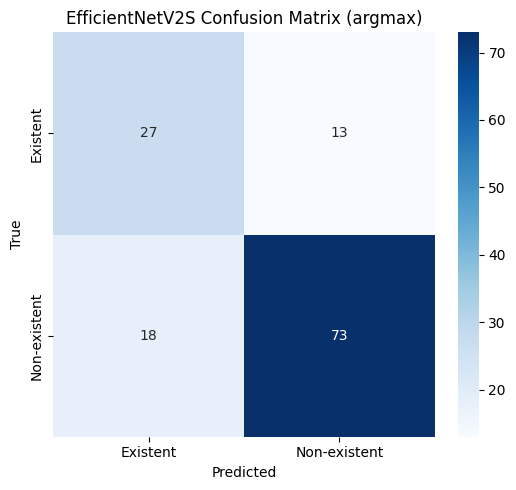

              precision    recall  f1-score   support

    Existent       0.60      0.68      0.64        40
Non-existent       0.85      0.80      0.82        91

    accuracy                           0.76       131
   macro avg       0.72      0.74      0.73       131
weighted avg       0.77      0.76      0.77       131

✅ EfficientNetV2S | Argmax ACC=0.7634 F1W=0.7670
✅ EfficientNetV2S | Best t=0.62 -> TEST ACC=0.7481 F1W=0.7381


In [15]:
results = []
name = "EfficientNetV2S"
print("\n" + "="*70)
print("🚀 Training:", name)
print("="*70)

model, base, fine_tune_at = make_model(name)

print("🧩 Stage 1: warmup (frozen backbone)")
fit_model(model, epochs=20, lr=2e-4)

print("🔧 Stage 2: fine-tune (unfreeze last layers)")
base.trainable = True
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False
freeze_bn(model)
fit_model(model, epochs=36, lr=6e-6)

acc_arg, f1_arg, y_true, y_pred, _ = eval_on_test(model)
show_confusion(y_true, y_pred, f"{name} Confusion Matrix (argmax)")

best_t, best_val_f1 = best_threshold_on_val(model)
acc_thr, f1_thr, y_true_t, y_pred_t = eval_threshold(model, best_t)

results.append({
    "Model": name,
    "Argmax_ACC": acc_arg,
    "Argmax_F1W": f1_arg,
    "Best_t(VAL)": best_t,
    "Test_ACC@t": acc_thr,
    "Test_F1W@t": f1_thr
})

print(f"✅ {name} | Argmax ACC={acc_arg:.4f} F1W={f1_arg:.4f}")
print(f"✅ {name} | Best t={best_t:.2f} -> TEST ACC={acc_thr:.4f} F1W={f1_thr:.4f}")


In [16]:
# ✅ save the trained model (best)
model.save(f"{name}_erythema.keras")

# or weights only (lighter)
# model.save_weights(f"{name}_erythema.weights.h5")

import tensorflow as tf
tf.keras.backend.clear_session()
print(f"✅ Saved + cleared session for {name}")


✅ Saved + cleared session for EfficientNetV2S


# Cell 17 — Model Comparison & Final Selection

In [17]:
results_df = pd.DataFrame(results).sort_values("Test_F1W@t", ascending=False).reset_index(drop=True)
display(results_df)

best = results_df.iloc[0]
print(f"\n🏆 BEST MODEL = {best['Model']} | Test_ACC@t={best['Test_ACC@t']:.4f} | Test_F1W@t={best['Test_F1W@t']:.4f} | Best_t={best['Best_t(VAL)']:.2f}")

results_df.to_csv("erythema_augtrain_cleanval_best3_results.csv", index=False)
print("✅ Saved: erythema_augtrain_cleanval_best3_results.csv")


,Model,Argmax_ACC,Argmax_F1W,Best_t(VAL),Test_ACC@t,Test_F1W@t
0,EfficientNetV2S,0.763359,0.766976,0.62,0.748092,0.738061



🏆 BEST MODEL = EfficientNetV2S | Test_ACC@t=0.7481 | Test_F1W@t=0.7381 | Best_t=0.62
✅ Saved: erythema_augtrain_cleanval_best3_results.csv
